# $\color{blue}{\text{Model Predictive Control - EL2700}}$

## Assignment 1: State feedback controller design

### Throughout these assignments, we will consider the design of a control system for an inverted pendulum on a cart, see Figure below. The objective will be to move the cart from one position to the other while maintaining the pendulum upright. This system has challenging dynamics, similar to the ones that you can find when designing control systems for Segway vehicles, space rockets and many other interesting systems.

### In this task, we will design a discrete-time linear state-feedback controller for our system. To thisend, you will linearize the nonlinear continuous-time dynamics, compute a discrete-time modelwhich describes the state evolution between sampling instances, and use this model to design alinear state feedback controller which achieves the desired control performance.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math
import time
import cvxpy as cp
import scipy.signal
from numpy import linalg as LA
from scipy.integrate import odeint
from numpy.linalg import matrix_rank

## Parameters of the inverted pendulum

![title](inverted_pendulum.png)

In [2]:
M  = 0.5          # Mass of the cart (kg)
m  = 0.2          # Mass of the inverted pendulum (kg)
I  = 0.006        # Moment of inertia of the inverted pendulum (kg-m^2)
l  = 0.3          # Length of the pendulum (m)
bc = 0.1          # Coefficient of friction for the cart
bp = 0.012        # Coefficient of friction for the pendulum
g  = 9.81         # Acceleration due to gravity (m/s^2)
Ts = 0.1          # Sampling time (s)

# Dynamic model of an inverted pendulum

## Case I: Continuous-time nonlinear dynamics of the inverted pendulum

### To develop the nonlinear model of the system dynamics, we will use the notation introduced in Figure above : $x$ is the cart position, $\theta$ is the pendulum angle, $F$ is the force applied to the cart, and $w$ is an external disturbance force (force due to wind onthe pendulum). By classical mechanics, the system dynamics can be described by the following differential equations.

### $\begin{equation}
\begin{aligned}
&(M+m) \ddot{x} - m l \ddot{\theta} \cos \theta + m l \dot{\theta}^{2} \sin \theta + b_c \dot{x} &&= F - w \\ 
&(I+ml^2) \ddot{\theta} + b_p \dot{\theta} - m g l \sin \theta - l w \cos \theta &&= m l \ddot{x} \cos \theta \\
\end{aligned}
\end{equation}$

### By introducing the state variables $x_{1} = x$, $x_{2} = \dot{x} $, $x_{3} = \theta $, $x_{4} = \dot{\theta}$, we obtain the following state-space form:

### $\begin{equation}
    \begin{aligned}
    &\dot{x}_{1}  = x_{2} && \dot{x}_{2}  = f_1(x_{2}, x_{3}, x_{4}, F, w) \\
    &\dot{x}_{3}  = x_{4} \hspace{20mm}&& \dot{x}_{4}  = f_2(x_{2}, x_{3}, x_{4}, F, w)\\
    \end{aligned}
\end{equation}$

### where,

### $ \begin{equation}
     \begin{aligned}
    f_{1}(x_{2}, x_{3}, x_{4}, F, w) &= \frac{1}{M + m - \frac{m^2l^2\cos^2{x_3}}{I + m l^2}} \left(F + \left(\frac{ml^2\cos^2{x_3}}{I + ml^2} - 1\right)w - b_c x_2 \right.  \\ & \qquad \left. - mlx_4^2\sin{x_3} + \frac{m^2 l^2 g \sin{x_3}\cos{x_3}}{I + m l^2} - \frac{m l b_p x_4 \cos{x_3}}{I + m l^2} \right)
    \end{aligned}
\end{equation}$

### $ \begin{equation}
      \begin{aligned}
f_{2}(x_{2}, x_{3}, x_{4}, F, w) &= \frac{1}{I + m l^2 - \frac{m^2 l^2 \cos^2{x_3}}{M + m}} \left( \frac{m l \cos{x_3}}{M + m} F + \frac{M l \cos{x_3}}{M + m}w - b_p x_4 \right.\\ & \qquad \left. + m g l \sin{x_3}  - \frac{m^2 l^2 x_4^2 \sin{x_3}\cos{x_3}}{M + m}   - \frac{m l b_c x_2 \cos{x_3}}{M + m} \right)
\end{aligned}
\end{equation}$

## Therefore, the nonlinear dynamics of an inverted pendulum can be represented as $\dot x = f_c(x,t,F,w)$

In [3]:
def nonlinearSystemDynamics(x,t,u,w):
    F = u                  # Horizontal force on the pendulum
    W = w                  # Horizontal wind force on the pendulum (in a direction opposite to the motion of the pendulum)
    p = x[0]               # Position of the cart
    v = x[1]               # Linear velocity of the cart
    theta = x[2]           # Angular position of the pendulum
    omega = x[3]           # Angular velocity of the pendulum
    der_x = np.zeros(4)    # Derivative of state x
    der_x[0] = v
    der_x[1] = ( F + (m*l**2*np.cos(theta)**2/(I + m*l**2)-1)* W - bc*v - m*l*np.sin(theta)*omega**2 + m**2*l**2*g*np.sin(theta)*np.cos(theta)/(I+m*l**2) - m*l*bp*np.cos(theta)*omega/(I+m*l**2) ) / ( M + m - m**2*l**2*np.cos(theta)**2/(I+m*l**2) )
    der_x[2] = omega 
    der_x[3] = ( m*l*np.cos(theta)*F/(M+m) + M*l*np.cos(theta)*W/(M+m) - bp*omega + m*g*l*np.sin(theta) - m**2*l**2*omega**2*np.sin(theta)*np.cos(theta)/(M+m) - m*l*bc*v*np.cos(theta)/(M+m) ) / ( I + m*l**2 - m**2*l**2*np.cos(theta)**2/(M+m) )
    return der_x

## Case II: Continuous-time linearized dynamics of the inverted pendulum; linearization is performed about the upright, unstable equilibrium point $(\bar{x}, \bar{u})$

### $\dot x = A_c~x + B_c~u + B_{wc}~w, ~~ y = C_c~x + D_c~u$

### where, $A_c = \left.\frac{\partial f_c(x, t, u)}{\partial x}\right|_{(\bar{x},~\bar{u},~\bar{w})}$, $ B_c = \left.\frac{\partial f_c(x, t, u)}{\partial u}\right|_{(\bar{x},~\bar{u},~\bar{w})}$, and $B_{wc} = \left.\frac{\partial f_c(x, t, u)}{\partial w}\right|_{(\bar{x},~\bar{u},~\bar{w})}$ can be expressed as

### $\begin{equation*}
\begin{aligned}
A_{c} &=\left[\begin{array}{cccc}{0} & {1} & {0} & {0} \\ {0} & {-b_{c} v_{2}} & {\frac{m^{2} l^{2} g v_{2}}{I+m l^{2}}} & {-\frac{m l b_{p} v_{2}}{I+m l^{2}}} \\ {0} & {0} & {0} & {1} \\ {0} & {-\frac{m l b_{c} v_{1}}{m+M}} & {m g l v_{1}} & {-b_{p} v_{1}}\end{array}\right]  \hspace{20mm}
&&B_{c} =\left[\begin{array}{c}{0}\\{v_2} \\ {0} \\ {\frac{m l v_{1}}{m+M}}\end{array}\right]  \\
B_{wc} &=\left[\begin{array}{c}{0}\\{-\frac{I v_2}{I + m l^2}} \\ {0} \\ {\frac{m l v_{1}}{m+M}}\end{array}\right]\\
C_{c} &=\left[\begin{array}{llll}{1} & {0} & {0} & {0}\end{array}\right]  
&&D_c = 0\\
v_1& = \frac{m +M}{I (m+M) + m M l^2} 
&&\hspace{1mm}v_2 = \frac{I + m l^2}{I (m+M) + m M l^2}
\end{aligned}
\end{equation*}$

### Augmenting control and disturbance input, we can rewrite the above state-space equation as follows:

### $\dot x = A_c~x + \left[\begin{array}{cc}{B_c} & {B_{wc}}\end{array}\right]~\left[\begin{array}{c}{u} \\{w}\end{array}\right], ~~ y = C_c~x + \left[\begin{array}{cc}{D_c} & {0}\end{array}\right]~\left[\begin{array}{c}{u} \\{w}\end{array}\right]$

#### ** The subscript c denotes continuous-time representation

In [4]:
v1 = (M + m)/(I*(M + m) + m*M*l**2)
v2 = (I + m*l**2)/(I*(M + m) + m*M*l**2)

# Ac matrix
a11  = 0 
a12  = 1 
a13  = 0 
a14  = 0
a21  = 0
a22  = -bc*v2
a23  = m**2*l**2*g*v2/(I+m*l**2)
a24  = -m*l*bp*v2/(I+m*l**2)
a31  = 0
a32  = 0
a33  = 0
a34  = 1
a41  = 0
a42  = -(m*l*bc*v1)/(m+M)
a43  = m*g*l*v1
a44  = -bp*v1        
Ac =np.array([[a11, a12, a13, a14],
              [a21, a22, a23, a24],
              [a31, a32, a33, a34],
              [a41, a42, a43, a44]])     

# Bc matrix       
Bc = np.array([
    [0],
    [v2],
    [0],
    [m*l*v1/(m+M)]
])

# Bwc matrix (disturbance matrix)      
Bwc = np.array([
    [0],
    [-(I*v2)/(I+m*l**2)],
    [0],
    [m*l*v1/(m+M)]
])

# Output matrices
Cc = np.array([[1.0, 0.0, 0.0, 0.0]])
#Cc = Cc[np.newaxis, :]

Dc = np.array([[0.0]])  

# number of states and number or inputs      
[nx, nu] = Bc.shape 

# Continuous-time system in state space (Disturbance is not included)
sys  = (Ac, Bc, Cc, Dc)

# Continuous-time system in state space (Disturbance is included)
AcAug = Ac
BcAug = np.concatenate((Bc,Bwc), axis=1)
CcAug = Cc
DcAug = [Dc,0.0]
sysAug = (AcAug, BcAug, CcAug, DcAug)

# Continuous-time system dynamics
def linearizedSystemDynamics(x,t,u,w):
    dxdt = Ac.dot(x) + Bc.dot(u) + Bwc.dot(w)
    return dxdt


## Controller design: state feedback controller design by pole placement method with reference feed forward

### First, we will discretize the continuous-time linearized state space model of the inverted pendulum using zero-order-hold (zoh) to have the following discrete-time state space representation

### $x_{t+1} = A~x_t + B~u_t + B_w~w_t, ~~ y_t = C~x_t + D~u_t$

### We will then design a state feedback controller of the form $u = -L x + l_r r$ to place the closed loop poles, i.e., the eigen values of $(A-BL)$ at the desired locations. The feedforwar gain, $l_r$ is computed as
### $\begin{equation}\label{eq:kf}
    l_r = \frac{1}{C (I - (A - B L))^{-1} B}
\end{equation}$

In [5]:
# Discretization of linear continous-time model by zero-order-hold (Disturbance is not included)
sysd = scipy.signal.cont2discrete(sys, Ts, method='zoh', alpha=None)
A   = sysd[0]
B   = sysd[1]
C   = sysd[2]
D   = sysd[3]

# Discretization of linear continous-time model by zero-order-hold (Disturbance is included)
sysdAug = scipy.signal.cont2discrete(sysAug, Ts, method='zoh', alpha=None)
BAug = sysdAug[1]
DAug = sysdAug[3]
Aa   = sysdAug[0]
Ba   = np.c_[BAug[:,0]]
Bw   = np.c_[BAug[:,1]]
Ca   = sysdAug[2]
Da   = DAug[0]
Dw   = DAug[1]

# Check actual and augmented (augmenting disturbance input) state-space model parameters
print("\n Discrete-time state space model of the inverted pendulum: \n A = \n", A)
print("\n B = \n", B)
print("\n C = \n", C)
print("\n D = \n", D)

print("\n Discrete-time augmented state space model of the inverted pendulum: \n Aa = \n", Aa)
print("\n Ba = \n", Ba)
print("\n Ca = \n", Ca)
print("\n Da = \n", Da)

# Check Reacability
W = np.zeros((nx,nx))
for i in range(nx):
    if i == 0:
        APoweri = np.eye(nx)
    else:
        APoweri = A**i
            
    W[:,i] = APoweri.dot(B)[:,0]
    
#print(np.round_(WAug, decimals = 2))

if matrix_rank(W) == nx:
    print("\n Awesome! The discrete-time linear system is reachable. Now, we will place closed-loop system poles by eigenvalue assignment.")


 Discrete-time state space model of the inverted pendulum: 
 A = 
 [[ 1.00000000e+00  9.90954686e-02  1.33600787e-02  1.71378166e-04]
 [ 0.00000000e+00  9.81904743e-01  2.70474758e-01  7.84581251e-03]
 [-0.00000000e+00 -2.26980610e-03  1.15660718e+00  1.02002803e-01]
 [ 0.00000000e+00 -4.59522184e-02  3.17780564e+00  1.09182011e+00]]

 B = 
 [[0.00904531]
 [0.18095257]
 [0.02269806]
 [0.45952218]]

 C = 
 [[1. 0. 0. 0.]]

 D = 
 [[0.]]

 Discrete-time augmented state space model of the inverted pendulum: 
 Aa = 
 [[ 1.00000000e+00  9.90954686e-02  1.33600787e-02  1.71378166e-04]
 [ 0.00000000e+00  9.81904743e-01  2.70474758e-01  7.84581251e-03]
 [-0.00000000e+00 -2.26980610e-03  1.15660718e+00  1.02002803e-01]
 [ 0.00000000e+00 -4.59522184e-02  3.17780564e+00  1.09182011e+00]]

 Ba = 
 [[0.00904531]
 [0.18095257]
 [0.02269806]
 [0.45952218]]

 Ca = 
 [[1. 0. 0. 0.]]

 Da = 
 [[0.]]

 Awesome! The discrete-time linear system is reachable. Now, we will place closed-loop system poles by 

## Simualtion of closed loop system

### Case I: Disturbance is ignored and the linear model of the inverted pendulum is incorporated in the simulation

In [7]:

import socket

#Initialization
UDP_IP_ADDRESS = "127.0.0.1"
SENSOR_UDP_PORT_NO = 6789
EDGE_UDP_PORT_NO = 6790

def call_u_linear(x0, xRef):
    clientSock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
    message = str(x0) + ' ' + str(xRef)
    print('Message = ', message)
    message = bytearray(message, encoding='UTF-8')
    clientSock.sendto(message, (UDP_IP_ADDRESS, EDGE_UDP_PORT_NO))
    
    serverSock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
    serverSock.bind((UDP_IP_ADDRESS, SENSOR_UDP_PORT_NO))
    data, addr = serverSock.recvfrom(65536)
    values = data.decode('UTF-8')[2:-2]
    u = float(values)
    print('Values = ', values, 'u = ', u)
    return u
    


In [8]:
phi0 = 30*np.pi/180
x0   = np.array([0, 0, phi0, 0]) # initial state

# Simulation time
t0 = 0
tf = 50
t  = np.arange(t0, tf+Ts, Ts)

# Store system trajectory and control input
state_dim = (4, len(t))
xsim = np.zeros(state_dim)
xsim[:,0] = x0
input_dim = (1,len(t))
u = np.zeros(input_dim)

# Position set point
xRef = 5.0;
xRefVec = np.ones(len(t))*xRef
thetaRefVec = np.zeros(len(t))

# Realized disturbance
w = [0.0]

# Simulate the state-feedback and feed forward controller with linearized continuous-time model 
# of the inverted pendulum
for i in range (len(t)-1):
    ts = [t[i], t[i+1]]
    #u[:,i] = -L.dot(x0) + lr*xRef
    u[:, i] = call_u_linear(x0, xRef)
    y  = odeint(linearizedSystemDynamics, x0, ts, args=(u[:,i],w))
    x0 = y[1]
    xsim[:,i+1] = x0



Message =  [0.         0.         0.52359878 0.        ] 5.0
Values =  -15.26739807 u =  -15.26739807
Message =  [-0.13110309 -2.62105468  0.25905774 -5.351813  ] 5.0
Values =  8.43882504 u =  8.43882504
Message =  [-0.31196206 -1.01851969 -0.04877761 -1.0217114 ] 5.0
Values =  2.55348858 u =  2.55348858
Message =  [-0.39062241 -0.55923826 -0.10036287 -0.05034297] 5.0
Values =  0.87891317 u =  0.87891317
Message =  [-0.43943982 -0.41761771 -0.09999655  0.05567915] 5.0
Values =  0.63899428 u =  0.63899428
Message =  [-0.47637036 -0.32104285 -0.09452546  0.05584453] 5.0
Values =  0.60245618 u =  0.60245618
Message =  [-0.50398813 -0.2313461  -0.08922923  0.05218327] 5.0
Values =  0.57855493 u =  0.57855493
Message =  [-0.52286344 -0.14619367 -0.08422314  0.0499113 ] 5.0
Values =  0.55375761 u =  0.55375761
Message =  [-0.53345832 -0.06573303 -0.07942094  0.04803124] 5.0
Values =  0.52916093 u =  0.52916093
Message =  [-0.53623857  0.01010494 -0.07479937  0.04623895] 5.0
Values =  0.50524

Values =  -0.01659319 u =  -0.01659319
Message =  [ 4.99376394e+00  5.22624911e-02  3.12602980e-03 -1.19828240e-03] 5.0
Values =  -0.01608759 u =  -0.01608759
Message =  [ 4.99883893e+00  4.92418087e-02  3.00957713e-03 -1.16860799e-03] 5.0
Values =  -0.01559075 u =  -0.01559075
Message =  [ 5.00361753e+00  4.63344260e-02  2.89604768e-03 -1.13915666e-03] 5.0
Values =  -0.0151028 u =  -0.0151028
Message =  [ 5.00811093e+00  4.35374730e-02  2.78541755e-03 -1.10995098e-03] 5.0
Values =  -0.01462387 u =  -0.01462387
Message =  [ 5.01233002e+00  4.08481018e-02  2.67766034e-03 -1.08101944e-03] 5.0
Values =  -0.01415402 u =  -0.01415402
Message =  [ 5.01628542e+00  3.82634972e-02  2.57274771e-03 -1.05237373e-03] 5.0
Values =  -0.01369339 u =  -0.01369339
Message =  [ 5.01998746e+00  3.57808624e-02  2.47064891e-03 -1.02405161e-03] 5.0
Values =  -0.01324196 u =  -0.01324196
Message =  [ 5.02344622e+00  3.33974460e-02  2.37133134e-03 -9.96054322e-04] 5.0
Values =  -0.01279983 u =  -0.01279983
Mes

Values =  0.00019383 u =  0.00019383
Message =  [ 5.00039037e+00 -7.03538927e-04 -3.78979818e-05  1.35104584e-05] 5.0
Values =  0.00018836 u =  0.00018836
Message =  [ 5.00032186e+00 -6.66868391e-04 -3.65783479e-05  1.32097633e-05] 5.0
Values =  0.00018295 u =  0.00018295
Message =  [ 5.00025695e+00 -6.31485799e-04 -3.52887909e-05  1.29037863e-05] 5.0
Values =  0.00017765 u =  0.00017765
Message =  [ 5.00019551e+00 -5.97356107e-04 -3.40291086e-05  1.26062981e-05] 5.0
Values =  0.00017241 u =  0.00017241
Message =  [ 5.00013743e+00 -5.64453807e-04 -3.27989307e-05  1.23082158e-05] 5.0
Values =  0.00016725 u =  0.00016725
Message =  [ 5.00008257e+00 -5.32750198e-04 -3.15983400e-05  1.20088800e-05] 5.0
Values =  0.00016219 u =  0.00016219
Message =  [ 5.00003083e+00 -5.02213503e-04 -3.04270931e-05  1.17152398e-05] 5.0
Values =  0.0001572 u =  0.0001572
Message =  [ 4.99998208e+00 -4.72817836e-04 -2.92849847e-05  1.14203007e-05] 5.0
Values =  0.0001523 u =  0.0001523
Message =  [ 4.99993622

Message =  [ 5.00000269e+00  3.06842422e-06  2.24850454e-07 -9.21125446e-08] 5.0
Values =  -1.23117163e-06 u =  -1.23117163e-06
Message =  [ 5.00000299e+00  2.85020641e-06  2.15699383e-07 -9.29330023e-08] 5.0
Values =  -1.18060661e-06 u =  -1.18060661e-06
Message =  [ 5.00000327e+00  2.64256526e-06  2.05958290e-07 -9.00751778e-08] 5.0
Values =  -1.11959773e-06 u =  -1.11959773e-06
Message =  [ 5.00000352e+00  2.44713642e-06  1.97375666e-07 -7.99950297e-08] 5.0
Values =  -1.10864534e-06 u =  -1.10864534e-06
Message =  [ 5.00000375e+00  2.25499373e-06  1.89343444e-07 -8.21760979e-08] 5.0
Values =  -1.06766821e-06 u =  -1.06766821e-06
Message =  [ 5.00000397e+00  2.07155639e-06  1.81210546e-07 -8.23857589e-08] 5.0
Values =  -1.02293506e-06 u =  -1.02293506e-06
Message =  [ 5.00000417e+00  1.89729391e-06  1.72556534e-07 -7.98856286e-08] 5.0
Values =  -9.67748277e-07 u =  -9.67748277e-07
Message =  [ 5.00000435e+00  1.73387354e-06  1.64938063e-07 -7.09928930e-08] 5.0
Values =  -9.55509389e-

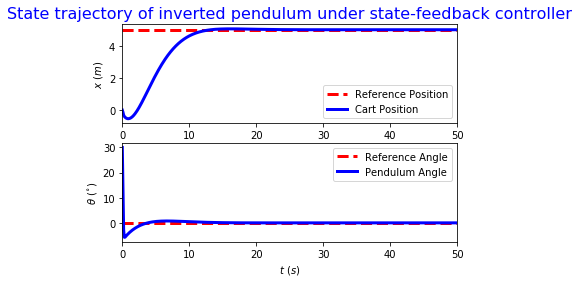

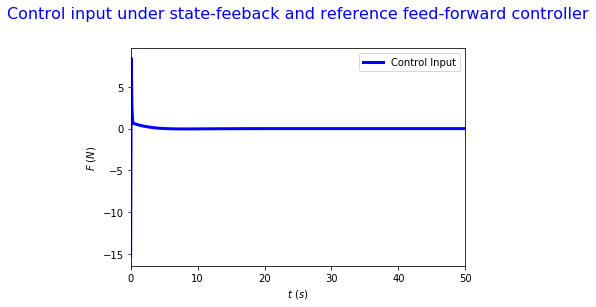

In [9]:
# Plot system trajectory and control input
plt.figure(1)
plt.subplot(2, 1, 1)
plt.plot(t, xRefVec, 'r--', linewidth=3, label='Reference Position')
plt.plot(t, xsim[0,:],'b',linewidth=3, label='Cart Position')
plt.xlim(t0, tf)
plt.ylabel(r'$x~(m)$')
plt.legend(loc='best')
plt.title('State trajectory of inverted pendulum under state-feedback controller', fontsize = 16, color = 'blue')

plt.subplot(2, 1, 2)
plt.plot(t, thetaRefVec, 'r--', linewidth=3, label='Reference Angle')
plt.plot(t, xsim[2,:]*(180/np.pi),'b',linewidth=3, label='Pendulum Angle')
plt.xlim(t0, tf)
plt.xlabel(r'$t~(s)$')
plt.ylabel(r'$\theta~(^{\circ})$')
plt.legend(loc='best')
plt.show()


plt.figure(2)
plt.plot(t, u[0,:], 'b', linewidth=3, label='Control Input')
plt.xlim(t0, tf)
plt.xlabel(r'$t~(s)$')
plt.ylabel(r'$F~(N)$')
plt.legend(loc='best')
plt.title('Control input under state-feeback and reference feed-forward controller', pad = 30, fontsize=16, color = 'blue')
plt.show()


### Case II: Disturbance is ignored and the nonlinear model of the inverted pendulum is incorporated in the simulation

In [ ]:
# Initialization
X0   = np.array([0, 0, phi0, 0]) # initial state

# Store system trajectory and control input
Xsim = np.zeros(state_dim)
Xsim[:,0] = X0
U = np.zeros(input_dim)

# Realized disturbance
w = 0.0

# Simulate the state-feedback and feed forward controller with nonlinear continuous-time model 
# of the inverted pendulum
for i in range (len(t)-1):
    ts = [t[i], t[i+1]]
    U[:,i] = -L.dot(X0) + lr*xRef
    Y  = odeint(nonlinearSystemDynamics, X0, ts, args=(U[:,i],w))
    X0 = Y[1]
    Xsim[:,i+1] = X0

# Plot system trajectory and control input
plt.figure(3)
plt.subplot(2, 1, 1)
plt.plot(t, xRefVec, 'r--', linewidth=3, label='Reference Position')
plt.plot(t, Xsim[0,:],'b',linewidth=3, label='Cart Position')
plt.xlim(t0, tf)
plt.ylabel(r'$x~(m)$')
plt.legend(loc='best')
plt.title('State trajectory of inverted pendulum under state-feedback controller', pad = 30, fontsize = 16, color = 'blue')
plt.subplot(2, 1, 2)

plt.plot(t, thetaRefVec, 'r--', linewidth=3, label='Reference Angle')
plt.plot(t, Xsim[2,:]*(180/np.pi),'b',linewidth=3, label='Pendulum Angle')
plt.xlim(t0, tf)
plt.xlabel(r'$t~(s)$')
plt.ylabel(r'$\theta~(^{\circ})$')
plt.legend(loc='best')
plt.show()

plt.figure(4)
plt.plot(t, U[0,:], 'b', linewidth=3, label='Control Input')
plt.xlim(t0, tf)
plt.xlabel(r'$t~(s)$')
plt.ylabel(r'$F~(N)$')
plt.legend(loc='best')
plt.title('Control input under state-feeback and reference feed-forward controller', pad = 30, fontsize=16, color = 'blue')
plt.show()


### Comparison: linear vs. nonlinear inverted pendulum model without disturbance

In [ ]:
fig, axs = plt.subplots(2, 1, constrained_layout=True)
axs[0].plot(t, xRefVec, 'r--', linewidth=3, label='Reference Position')
axs[0].plot(t, Xsim[0,:],'b--',linewidth=3, label='Using nonlinear model')
axs[0].plot(t, xsim[0,:],'k--',linewidth=3, label='Using linear model')
axs[0].set_title('Cart position \n')
axs[0].set_xlabel(r'$t~(s)$')
axs[0].set_ylabel(r'$x~(m)$')
axs[0].set_xlim([t0, tf])
axs[0].legend(loc='best')
fig.suptitle('Comparison of system trajectories: nonlinear vs. linear model of the inverted pendulum', fontsize=16, color = 'blue')

axs[1].plot(t, thetaRefVec, 'r--', linewidth=3, label='Reference Angle')
axs[1].plot(t, Xsim[2,:]*(180/np.pi),'b',linewidth=3, label='using nonlinear model')
axs[1].plot(t, xsim[2,:]*(180/np.pi),'k--',linewidth=3, label='using linear model')
axs[1].set_title('Pendulum Angle \n')
axs[1].set_xlabel(r'$t~(s)$')
axs[1].set_ylabel(r'$\theta (^{\circ})$')
axs[1].set_xlim([t0, tf])
axs[1].legend(loc='best')
fig.set_size_inches(8.5, 8.5, forward=True)

plt.show()

### Case III: The linear model of the inverted pendulum and the disturbance incorporated in the simulation

In [ ]:
# Initialization
phi0 = 30*np.pi/180
x0   = np.array([0, 0, phi0, 0]) # initial state

# Simulation time
t0 = 0
tf = 100
t  = np.arange(t0, tf+Ts, Ts)

# Store system trajectory and control input
state_dim = (nx, len(t))
xsim = np.zeros(state_dim)
xsim[:,0] = x0
input_dim = (nu,len(t))
u = np.zeros(input_dim)

# Position set point
xRef = 5.0;
xRefVec = np.ones(len(t))*xRef
thetaRefVec = np.zeros(len(t))

# Realized disturbance
wMag = 0.01
w = np.zeros(input_dim)
w = np.where(t < 50, w, wMag)

# Simulate the state-feedback and feed forward controller with linearized continuous-time model 
# of the inverted pendulum
for i in range (len(t)-1):
    ts = [t[i], t[i+1]]
    u[:,i] = -L.dot(x0) + lr*xRef
    y  = odeint(linearizedSystemDynamics, x0, ts, args=(u[:,i],w[:,i]))
    x0 = y[1]
    xsim[:,i+1] = x0

# Plot system trajectory and control input
plt.figure(figsize=(14, 10))
plt.subplot(221)
plt.plot(t, xRefVec, 'r--', linewidth=3, label='Reference Position')
plt.plot(t, xsim[0,:],'b',linewidth=3, label='Cart Position')
plt.xlim(t0, tf)
plt.ylabel(r'$x~(m)$')
plt.legend(loc='best')
plt.suptitle('State trajectory of inverted pendulum under state-feedback controller', fontsize = 16, color = 'blue')

plt.subplot(222)
plt.plot(t, xRefVec, 'r--', linewidth=3, label='Reference Position')
plt.plot(t, xsim[0,:],'b',linewidth=3, label='Cart Position')
plt.xlim(40, tf)
plt.ylim(4, 6)
plt.ylabel(r'$x~(m)$')
plt.legend(loc='best')

plt.subplot(223)
plt.plot(t, thetaRefVec, 'r--', linewidth=3, label='Reference Angle')
plt.plot(t, xsim[2,:]*(180/np.pi),'b',linewidth=3, label='Pendulum Angle')
plt.xlim(t0, tf)
plt.xlabel(r'$t~(s)$')
plt.ylabel(r'$\theta~(^{\circ})$')
plt.legend(loc='best')

plt.subplot(224)
plt.plot(t, thetaRefVec, 'r--', linewidth=3, label='Reference Angle')
plt.plot(t, xsim[2,:]*(180/np.pi),'b',linewidth=3, label='Pendulum Angle')
plt.xlim(40, tf)
plt.ylim(-1, 1)
plt.xlabel(r'$t~(s)$')
plt.ylabel(r'$\theta~(^{\circ})$')
plt.legend(loc='best')
plt.show()


plt.figure(figsize=(14, 10))
plt.subplot(221)
plt.plot(t, u[0,:], 'b', linewidth=3, label='Control Input')
plt.xlim(t0, tf)
plt.xlabel(r'$t~(s)$')
plt.ylabel(r'$F~(N)$')
plt.legend(loc='best')
plt.suptitle('Control input under state-feeback and reference feed-forward controller', fontsize=16, color = 'blue')

plt.subplot(222)
plt.plot(t, u[0,:], 'b', linewidth=3, label='Control Input')
plt.xlim(t0, tf)
plt.ylim(-0.1,0.1)
plt.xlabel(r'$t~(s)$')
plt.ylabel(r'$F~(N)$')
plt.legend(loc='best')

plt.subplot(212)
plt.plot(t, w[0,:], 'b', linewidth=3, label='Disturbance Input')
plt.xlim(t0, tf)
plt.xlabel(r'$t~(s)$')
plt.ylabel(r'$w~(N)$')
plt.legend(loc='best')
plt.show()


### Computing staeady state error
### $\begin{equation*} \tilde{y}_{s s}= \lim_{k\to\infty} r - y_k = - C [I - (A - B L)]^{-1} B_w w \end{equation*}$

In [ ]:
yss_sim = xRef - xsim[0,-1]
print("\n Steady state error in the cart position is %.2f m (from simulation)" %yss_sim)
Bw.dot(w)
yss_ana = -C.dot(np.linalg.inv(np.identity(nx) - A + B.dot(L)).dot(Bw.dot([wMag])))
print("\n Steady state error in the cart position is %.2f m (analytically computed)" %yss_ana)

if yss_sim - yss_ana < 1e-3:
    print(" \n Great! Verification successful")

### If we have a good estimate of disturbance, we can compute the feedforward gain online in each sampling instant to make the steady state to zero 

### $l_r = \frac{r_t - C[I-(A-BL)]^{-1}B_w w_t}{C[I-(A-BL)]^{-1}B r_t}$

In [ ]:
# Initialization
phi0 = 30*np.pi/180
x0   = np.array([0, 0, phi0, 0]) # initial state

# Simulation time
t0 = 0
tf = 100
t  = np.arange(t0, tf+Ts, Ts)

# Store system trajectory and control input
state_dim = (4, len(t))
xsim = np.zeros(state_dim)
xsim[:,0] = x0
input_dim = (1,len(t))
u = np.zeros(input_dim)

# Position set point
xRef = 5.0;
xRefVec = np.ones(len(t))*xRef
thetaRefVec = np.zeros(len(t))

# Realized disturbance
wMag = 0.01
w = np.zeros(input_dim)
w = np.where(t < 50, w, wMag)

# Simulate the state-feedback and feed forward controller with linearized continuous-time model 
# of the inverted pendulum
for i in range (len(t)-1):
    ts = [t[i], t[i+1]]
    num = xRefVec[i] - (C.dot((np.linalg.inv(np.identity(nx) - A + B.dot(L))).dot(Bw)))*w[0,i]
    den = (C.dot((np.linalg.inv(np.identity(nx) - A + B.dot(L))).dot(B)))*xRefVec[i]
    lr  = num/den
    u[:,i] = -L.dot(x0) + lr*xRef
    y  = odeint(linearizedSystemDynamics, x0, ts, args=(u[:,i],w[:,i]))
    x0 = y[1]
    xsim[:,i+1] = x0

# Plot system trajectory and control input
plt.figure(figsize=(14, 10))
plt.subplot(221)
plt.plot(t, xRefVec, 'r--', linewidth=3, label='Reference Position')
plt.plot(t, xsim[0,:],'b',linewidth=3, label='Cart Position')
plt.xlim(t0, tf)
plt.ylabel(r'$x~(m)$')
plt.legend(loc='best')
plt.suptitle('State trajectory of inverted pendulum under state-feedback controller with adaptive reference feed-forward', fontsize = 16, color = 'blue')

plt.subplot(222)
plt.plot(t, xRefVec, 'r--', linewidth=3, label='Reference Position')
plt.plot(t, xsim[0,:],'b',linewidth=3, label='Cart Position')
plt.xlim(40, tf)
plt.ylim(4, 6)
plt.ylabel(r'$x~(m)$')
plt.legend(loc='best')

plt.subplot(223)
plt.plot(t, thetaRefVec, 'r--', linewidth=3, label='Reference Angle')
plt.plot(t, xsim[2,:]*(180/np.pi),'b',linewidth=3, label='Pendulum Angle')
plt.xlim(t0, tf)
plt.xlabel(r'$t~(s)$')
plt.ylabel(r'$\theta~(^{\circ})$')
plt.legend(loc='best')

plt.subplot(224)
plt.plot(t, thetaRefVec, 'r--', linewidth=3, label='Reference Angle')
plt.plot(t, xsim[2,:]*(180/np.pi),'b',linewidth=3, label='Pendulum Angle')
plt.xlim(40, tf)
plt.ylim(-1, 1)
plt.xlabel(r'$t~(s)$')
plt.ylabel(r'$\theta~(^{\circ})$')
plt.legend(loc='best')
plt.show()


plt.figure(figsize=(14, 10))
plt.subplot(221)
plt.plot(t, u[0,:], 'b', linewidth=3, label='Control Input')
plt.xlim(t0, tf)
plt.xlabel(r'$t~(s)$')
plt.ylabel(r'$F~(N)$')
plt.legend(loc='best')
plt.suptitle('Control input under state-feeback and adaptive reference feed-forward controller', fontsize=16, color = 'blue')

plt.subplot(222)
plt.plot(t, u[0,:], 'b', linewidth=3, label='Control Input')
plt.xlim(t0, tf)
plt.ylim(-0.1,0.1)
plt.xlabel(r'$t~(s)$')
plt.ylabel(r'$F~(N)$')
plt.legend(loc='best')

plt.subplot(212)
plt.plot(t, w[0,:], 'b', linewidth=3, label='Disturbance Input')
plt.xlim(t0, tf)
plt.xlabel(r'$t~(s)$')
plt.ylabel(r'$w~(N)$')
plt.legend(loc='best')
plt.show()


## Integral Action

### Controllers based on state feedback achieve the correct steady-state response to command/reference signals by careful calibration of the gain $l_r$ as shown in the simulations above. However, one of the primary uses of feedback is to allow good performance in the presence of uncertainty and disturbance and hence requiring that we have an exact model of the process is undesirable.  Analternative to calibration is to make use of integral feedback, in which the controlleruses an integrator to provide zero steady-state error.

## System Augmentation

### The basic approach in integral feedback is to create a state within the controller that computes the integral of the error signal (difference between the actual output and the desired output, i.e., $e = y-r = C x - r$), which is then used as a feedback term. We do this by augmenting the description of the system with a new state $i$ , which is the integral of the error signal:

### $\begin{align*}
	i_{t+1} &= i_t + T_s(r_t - y_t) = i_t + T_s(r_t - C x_t)
\end{align*}$

### where, $T_s$ is the sampling time. The augmented state equations become:

### $\begin{align*}
	\begin{bmatrix}
	{x}_{t+1}\\ i_{t+1}
	\end{bmatrix} &=
	\begin{bmatrix}
	A & 0\\
	-h C & 1
	\end{bmatrix} \begin{bmatrix}
	{x}_t\\i_t
	\end{bmatrix} + \begin{bmatrix}
	B \\ 0
	\end{bmatrix}u_t +
\begin{bmatrix}
0\\
h
\end{bmatrix}r_t	+
\begin{bmatrix}
B_w\\0
\end{bmatrix}w_t
\end{align*}$

### Note that if we find a controller that stabilizes the system, then we will necessarily have $i_{t+1} = i_t $ in steady state and hence $y_t = C~x_t = r_t$ in steady state.

### Given the augmented system, we design a state space controller in the usual fashion, with a control law of the form 

### $\begin{align*}
u_t  &=  -L ~ x_t - l_i~i_t + l_r~r_t
     &= - \left[\begin{array}{cc}{L} & {l_i}\end{array}\right]~\left[\begin{array}{c}{x_t} \\{i_t}\end{array}\right]  + l_r~r_t
\end{align*}$

### where $L$ is the usual state feedback term, $l_i$ is the integral term, and $l_r$ is used to set the nominal input for the desired steady state.

### Now, the augmented state-space model $(\tilde{A}, \tilde{B}, \tilde{C}, \tilde{D})$  can be represented as:

### $ \begin{align*}
	\tilde{A} &=
	\begin{bmatrix}
	 A & 0\\
	-h C & 1
	\end{bmatrix} \\
    \tilde{B} &= \begin{bmatrix}
	B \\ 0
	\end{bmatrix}\\
    \tilde{C} &= \begin{bmatrix}
	 C & 0
	\end{bmatrix} \\
    \tilde{D} &= D
    \end{align*} $
    
### In order to place the closed loop poles at the desired locations, the augmented system $(\tilde{A}, \tilde{B})$ has to be reachable. Therefore, we will first test the reachability of the augmented system. The augmented system is reachable if the matrix $ W = \begin{bmatrix} \tilde{B} & \tilde{A}\tilde{B} & \tilde{A}^2\tilde{B} & \tilde{A}^3\tilde{B} \end{bmatrix}$ has full rank.

In [ ]:
# Augmented state-space model
Aub  = np.concatenate((A, np.zeros((4,1))), axis = 1)
Alb  = np.concatenate((-Ts*C, np.ones((1,1))),axis = 1)
AAug = np.concatenate((Aub,Alb), axis = 0)
BAug = np.concatenate((B, [[0.0]]),axis = 0)
CAug = np.concatenate((C, [[0.0]]),axis = 1)
DAug = D

nxAug = nx+1
# Compute reachability matrix
WAug = np.zeros((nxAug,nxAug))
for i in range(nxAug):
    if i == 0:
        AAugPoweri = np.eye(nxAug)
    else:
        AAugPoweri = AAug**i
            
    WAug[:,i] = AAugPoweri.dot(BAug)[:,0]
    
#print(np.round_(WAug, decimals = 2))

if matrix_rank(WAug) == nxAug:
    print("\n  Awesome! Augmented system is reachable")



### Great News! The augmented system $(\tilde{A},\tilde{B})$ is reachable, which means we can design a state feedback controller to place the closed-loop system poles at the desired locations. To this end, we will first plot the open loop poles of the augmented system and then we will assign them at desired locations via eigen value assignment.

In [ ]:
# Pole location of the original unstable system
openLoopPolesAug, _ = LA.eig(AAug) 
print(" \n Open-loop poles are located at: ", openLoopPolesAug)

# Desired pole locations
p1    = 0.1 + 0.1j
p2    = 0.1 - 0.1j
p3    = 0.97 + 0.02j
p4    = 0.97 - 0.02j
p5    = 0.8
polesAug = np.array([p1, p2, p3, p4, p5])

# Pole-placement method
fsfAug   = scipy.signal.place_poles(AAug, BAug, polesAug, method='YT')
closedLoopPolesAug = fsfAug.computed_poles
print(" \n Closed-loop poles are located at: ", closedLoopPolesAug)

# Plot open-loop and closed-loop poles
t1 = np.linspace(0, 2*np.pi, 401)
plt.figure(figsize=(6,6))
plt.plot(np.cos(t1), np.sin(t1), 'k--', linewidth=2)  # unit circle
plt.plot(openLoopPolesAug.real, openLoopPolesAug.imag,'ro',  markersize=16, label='open-loop poles')
plt.plot(closedLoopPolesAug.real, closedLoopPolesAug.imag,'bx', markersize=16, label='closed-loop poles')
plt.grid()
plt.axis('image')
plt.axis([-1.8, 1.8, -1.8, 1.8])
plt.title('Pole zero plot of the augmented plant with and without state-feedback controller', pad = 30, fontsize =16, color = 'blue')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, numpoints=1)
plt.show()

# Feedback gain by pole placement method
LAug = fsfAug.gain_matrix
print(" \n Feedback gain =", LAug)
LAugSF = LAug[0:1,0:4]
LAugInt = LAug[0,4]
print(" \n State Feedback gain =", LAugSF)
print(" \n Integral gain =", LAugInt)

# feedforward gain of the controller
lrAug = 1/(np.dot(C, np.dot(LA.inv(np.identity(4) - A + B*L), B)))
print(" \n Feed-forward gain =", lr)


### Simulation with linear inverted pendulum model

In [ ]:
# Initialization
phi0 = 30*np.pi/180
x0   = np.array([0, 0, phi0, 0]) # initial state

# Simulation time
t0 = 0
tf = 100
t  = np.arange(t0, tf+Ts, Ts)

# Store system trajectory and control input
state_dim = (4, len(t))
xsim = np.zeros(state_dim)
xsim[:,0] = x0
input_dim = (1,len(t))
u = np.zeros(input_dim)

# Position set point
xRef = 5.0;
xRefVec = np.ones(len(t))*xRef
thetaRefVec = np.zeros(len(t))

# Realized disturbance
wMag = 0.01
w = np.zeros(input_dim)
w = np.where(t < 50, w, wMag)

# Initial integral error 
Ierr = 0
xPos = x0[0]

# Simulate the state-feedback and feed forward controller with linearized continuous-time model 
# of the inverted pendulum
for i in range (len(t)-1):
    ts = [t[i], t[i+1]]
    Ierr += Ts*(xRefVec[i]-xPos) 
    u[:,i] = -LAugSF.dot(x0) - LAugInt*Ierr + lrAug*xRef
    y  = odeint(linearizedSystemDynamics, x0, ts, args=(u[:,i],w[:,i]))
    x0 = y[1]
    xsim[:,i+1] = x0
    xPos = x0[0]

# Plot system trajectory and control input
plt.figure(figsize=(14, 10))
plt.subplot(221)
plt.plot(t, xRefVec, 'r--', linewidth=3, label='Reference Position')
plt.plot(t, xsim[0,:],'b',linewidth=3, label='Cart Position')
plt.xlim(t0, tf)
plt.ylabel(r'$x~(m)$')
plt.legend(loc='best')
plt.suptitle('State trajectory of inverted pendulum  under state-feeback controller with integral action and reference feed-forward', fontsize = 16, color = 'blue')

plt.subplot(222)
plt.plot(t, xRefVec, 'r--', linewidth=3, label='Reference Position')
plt.plot(t, xsim[0,:],'b',linewidth=3, label='Cart Position')
plt.xlim(40, tf)
plt.ylim(4, 6)
plt.ylabel(r'$x~(m)$')
plt.legend(loc='best')

plt.subplot(223)
plt.plot(t, thetaRefVec, 'r--', linewidth=3, label='Reference Angle')
plt.plot(t, xsim[2,:]*(180/np.pi),'b',linewidth=3, label='Pendulum Angle')
plt.xlim(t0, tf)
plt.xlabel(r'$t~(s)$')
plt.ylabel(r'$\theta~(^{\circ})$')
plt.legend(loc='best')

plt.subplot(224)
plt.plot(t, thetaRefVec, 'r--', linewidth=3, label='Reference Angle')
plt.plot(t, xsim[2,:]*(180/np.pi),'b',linewidth=3, label='Pendulum Angle')
plt.xlim(40, tf)
plt.ylim(-1, 1)
plt.xlabel(r'$t~(s)$')
plt.ylabel(r'$\theta~(^{\circ})$')
plt.legend(loc='best')
plt.show()


plt.figure(figsize=(14, 10))
plt.subplot(221)
plt.plot(t, u[0,:], 'b', linewidth=3, label='Control Input')
plt.xlim(t0, tf)
plt.xlabel(r'$t~(s)$')
plt.ylabel(r'$F~(N)$')
plt.legend(loc='best')
plt.suptitle('Control input under state-feeback controller with integral action and reference feed-forward', fontsize=16, color = 'blue')

plt.subplot(222)
plt.plot(t, u[0,:], 'b', linewidth=3, label='Control Input')
plt.xlim(t0, tf)
plt.ylim(-0.1,0.1)
plt.xlabel(r'$t~(s)$')
plt.ylabel(r'$F~(N)$')
plt.legend(loc='best')

plt.subplot(212)
plt.plot(t, w[0,:], 'b', linewidth=3, label='Disturbance Input')
plt.xlim(t0, tf)
plt.xlabel(r'$t~(s)$')
plt.ylabel(r'$w~(N)$')
plt.legend(loc='best')
plt.show()


### Simulation with nonlinear inverted pendulum model

In [ ]:
lr# Initialization
phi0 = 30*np.pi/180
x0   = np.array([0, 0, phi0, 0]) # initial state

# Simulation time
t0 = 0
tf = 100
t  = np.arange(t0, tf+Ts, Ts)

# Store system trajectory and control input
state_dim = (4, len(t))
xsim = np.zeros(state_dim)
xsim[:,0] = x0
input_dim = (1,len(t))
u = np.zeros(input_dim)

# Position set point
xRef = 5.0;
xRefVec = np.ones(len(t))*xRef
thetaRefVec = np.zeros(len(t))

# Realized disturbance
wMag = 0.01
w = np.zeros(input_dim)
w = np.where(t < 50, w, wMag)

# Initial integral error 
Ierr = 0
xPos = x0[0]

# Simulate the state-feedback and feed forward controller with linearized continuous-time model 
# of the inverted pendulum
for i in range (len(t)-1):
    ts = [t[i], t[i+1]]
    Ierr += Ts*(xRefVec[i]-xPos) 
    u[:,i] = -LAugSF.dot(x0) - LAugInt*Ierr + lrAug*xRef
    y  = odeint(nonlinearSystemDynamics, x0, ts, args=(u[:,i],w[:,i]))
    x0 = y[1]
    xsim[:,i+1] = x0
    xPos = x0[0]

# Plot system trajectory and control input
plt.figure(figsize=(14, 10))
plt.subplot(221)
plt.plot(t, xRefVec, 'r--', linewidth=3, label='Reference Position')
plt.plot(t, xsim[0,:],'b',linewidth=3, label='Cart Position')
plt.xlim(t0, tf)
plt.ylabel(r'$x~(m)$')
plt.legend(loc='best')
plt.suptitle('State trajectory of inverted pendulum  under state-feeback controller with integral action and reference feed-forward',fontsize = 16, color = 'blue')

plt.subplot(222)
plt.plot(t, xRefVec, 'r--', linewidth=3, label='Reference Position')
plt.plot(t, xsim[0,:],'b',linewidth=3, label='Cart Position')
plt.xlim(40, tf)
plt.ylim(4, 6)
plt.ylabel(r'$x~(m)$')
plt.legend(loc='best')

plt.subplot(223)
plt.plot(t, thetaRefVec, 'r--', linewidth=3, label='Reference Angle')
plt.plot(t, xsim[2,:]*(180/np.pi),'b',linewidth=3, label='Pendulum Angle')
plt.xlim(t0, tf)
plt.xlabel(r'$t~(s)$')
plt.ylabel(r'$\theta~(^{\circ})$')
plt.legend(loc='best')

plt.subplot(224)
plt.plot(t, thetaRefVec, 'r--', linewidth=3, label='Reference Angle')
plt.plot(t, xsim[2,:]*(180/np.pi),'b',linewidth=3, label='Pendulum Angle')
plt.xlim(40, tf)
plt.ylim(-1, 1)
plt.xlabel(r'$t~(s)$')
plt.ylabel(r'$\theta~(^{\circ})$')
plt.legend(loc='best')
plt.show()


plt.figure(figsize=(14, 10))
plt.subplot(221)
plt.plot(t, u[0,:], 'b', linewidth=3, label='Control Input')
plt.xlim(t0, tf)
plt.xlabel(r'$t~(s)$')
plt.ylabel(r'$F~(N)$')
plt.legend(loc='best')
plt.suptitle('Control input under state-feeback controller with integral action and reference feed-forward', fontsize=16, color = 'blue')

plt.subplot(222)
plt.plot(t, u[0,:], 'b', linewidth=3, label='Control Input')
plt.xlim(t0, tf)
plt.ylim(-0.1,0.1)
plt.xlabel(r'$t~(s)$')
plt.ylabel(r'$F~(N)$')
plt.legend(loc='best')

plt.subplot(212)
plt.plot(t, w[0,:], 'b', linewidth=3, label='Disturbance Input')
plt.xlim(t0, tf)
plt.xlabel(r'$t~(s)$')
plt.ylabel(r'$w~(N)$')
plt.legend(loc='best')
plt.show()


## All done!